In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score



データ読み取り

In [3]:
df=pd.read_csv('learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=0)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [4]:
class DNN_5(nn.Module):
    def __init__(self, input_dim,dropout1,dropout2):
        super(DNN_5, self).__init__()
        self.layer1 = nn.Linear(input_dim,32)
        self.layer2 = nn.Linear(32,16)
        self.layer3 = nn.Linear(16, 8)
        self.layer4 = nn.Linear(8, 4)
        self.output_layer = nn.Linear(4, 1)

        self.bn1=nn.BatchNorm1d(32)
        self.bn2=nn.BatchNorm1d(16)
        self.bn3=nn.BatchNorm1d(8)
        self.bn4=nn.BatchNorm1d(4)

        self.dropout1 = nn.Dropout(dropout1)
        self.dropout2 = nn.Dropout(dropout2)        
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        
        x = torch.relu(self.bn2(self.layer2(x)))
        

        x = torch.relu(self.bn3(self.layer3(x)))
        x = self.dropout1(x)

        x = torch.relu(self.bn4(self.layer4(x)))
        x = self.dropout2(x)

        x = torch.sigmoid(self.output_layer(x)) 
        return x
    

学習データセットの作成

In [5]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=128, shuffle=False)

In [6]:
def objective(trial):
    # ハイパーパラメータのサンプリング
    dropout1 = trial.suggest_float("dropout1", 0, 0.5, step=0.05)
    dropout2 = trial.suggest_float("dropout2", 0, 0.5, step=0.05)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)  
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   

    # モデル定義
    model = DNN_5(
        input_dim=X_train_tensor.shape[1],
        dropout1=dropout1,
        dropout2=dropout2,
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Early Stoppingの設定
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    # 訓練ループ
    num_epochs = 300
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch.squeeze())
            loss.backward()
            optimizer.step()

        # バリデーション評価
        model.eval()
        val_loss = 0
        val_true, val_pred = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss += criterion(val_outputs, y_val.squeeze()).item()
                predictions = (val_outputs >=0.5).float()
                val_true.extend(y_val.cpu().numpy())
                val_pred.extend(predictions.cpu().numpy())

        val_loss /= len(val_loader)

        # Early Stopping判定
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Optunaへのログ
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # 最終的な評価指標を計算
    mcc = matthews_corrcoef(val_true, val_pred)
    print(f"Final MCC: {mcc:.4f}")

    return mcc  # mccを返す


In [7]:
device_id = 0  # 使用するGPUのID（0または1）
torch.cuda.set_device(device_id)
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

# Optunaの設定
study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)

# 結果表示
print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)

[I 2024-12-18 13:57:47,966] A new study created in memory with name: no-name-62d5b1c2-7407-4657-9f17-9a46cad27b53


/tmp/ipykernel_41854/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_41854/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:57:56,193] Trial 0 finished with value: 0.17672273767472715 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.05, 'learning_rate': 0.0013541526058020697, 'weight_decay': 2.583004916799215e-05}. Best is trial 0 with value: 0.17672273767472715.


Early stopping at epoch 48
Final MCC: 0.1767


/tmp/ipykernel_41854/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_41854/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:57:58,591] Trial 1 finished with value: 0.14036580262253434 and parameters: {'dropout1': 0.0, 'dropout2': 0.1, 'learning_rate': 0.0017915177874711962, 'weight_decay': 0.00012827068648428412}. Best is trial 0 with value: 0.17672273767472715.


Early stopping at epoch 19
Final MCC: 0.1404


/tmp/ipykernel_41854/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_41854/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:58:10,561] Trial 2 finished with value: 0.12646726410719678 and parameters: {'dropout1': 0.0, 'dropout2': 0.4, 'learning_rate': 0.00025379713969531065, 'weight_decay': 0.014872943822149421}. Best is trial 0 with value: 0.17672273767472715.


Early stopping at epoch 82
Final MCC: 0.1265


/tmp/ipykernel_41854/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_41854/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:58:12,019] Trial 3 finished with value: 0.0 and parameters: {'dropout1': 0.4, 'dropout2': 0.0, 'learning_rate': 2.9540105427615587e-05, 'weight_decay': 0.01827346724724896}. Best is trial 0 with value: 0.17672273767472715.


Early stopping at epoch 10
Final MCC: 0.0000


/tmp/ipykernel_41854/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_41854/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:58:15,132] Trial 4 finished with value: 0.06720719249224055 and parameters: {'dropout1': 0.1, 'dropout2': 0.4, 'learning_rate': 0.0013964086772432459, 'weight_decay': 2.9766927723441145e-05}. Best is trial 0 with value: 0.17672273767472715.


Early stopping at epoch 20
Final MCC: 0.0672


/tmp/ipykernel_41854/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_41854/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:58:25,199] Trial 5 finished with value: 0.24869900520596874 and parameters: {'dropout1': 0.25, 'dropout2': 0.45, 'learning_rate': 0.0003731896111959654, 'weight_decay': 0.000592263086743095}. Best is trial 5 with value: 0.24869900520596874.


Early stopping at epoch 71
Final MCC: 0.2487


/tmp/ipykernel_41854/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_41854/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:58:26,598] Trial 6 finished with value: 0.08890616454793629 and parameters: {'dropout1': 0.45, 'dropout2': 0.45, 'learning_rate': 4.4812080773100364e-05, 'weight_decay': 0.00041524996372161555}. Best is trial 5 with value: 0.24869900520596874.
/tmp/ipykernel_41854/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fea

Early stopping at epoch 10
Final MCC: 0.0889


[I 2024-12-18 13:58:52,488] Trial 8 finished with value: 0.2186729725346097 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.35000000000000003, 'learning_rate': 8.503738616449068e-05, 'weight_decay': 0.002883356885348577}. Best is trial 5 with value: 0.24869900520596874.
/tmp/ipykernel_41854/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_41854/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:58:52,570] Trial 9 pruned. 
[I 2024-12-18 13:58:52,660] Trial 10 pru

Early stopping at epoch 212
Final MCC: 0.2187


[I 2024-12-18 13:58:52,753] Trial 11 pruned. 
[I 2024-12-18 13:58:52,845] Trial 12 pruned. 
[I 2024-12-18 13:58:52,936] Trial 13 pruned. 
[I 2024-12-18 13:58:53,027] Trial 14 pruned. 
[I 2024-12-18 13:58:53,117] Trial 15 pruned. 
[I 2024-12-18 13:58:55,733] Trial 16 finished with value: 0.0 and parameters: {'dropout1': 0.5, 'dropout2': 0.4, 'learning_rate': 0.0073660496775123825, 'weight_decay': 0.0005596935414774332}. Best is trial 5 with value: 0.24869900520596874.
/tmp/ipykernel_41854/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_41854/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_

Early stopping at epoch 32
Final MCC: 0.0000


[I 2024-12-18 13:59:13,907] Trial 18 finished with value: 0.2686920389979384 and parameters: {'dropout1': 0.25, 'dropout2': 0.45, 'learning_rate': 9.886951256624949e-05, 'weight_decay': 0.0001259392596740048}. Best is trial 18 with value: 0.2686920389979384.


Early stopping at epoch 237
Final MCC: 0.2687


/tmp/ipykernel_41854/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_41854/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:59:18,998] Trial 19 finished with value: 0.055803058295103763 and parameters: {'dropout1': 0.2, 'dropout2': 0.5, 'learning_rate': 0.0004912138363261934, 'weight_decay': 8.552287607046636e-05}. Best is trial 18 with value: 0.2686920389979384.
/tmp/ipykernel_41854/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This featu

Early stopping at epoch 56
Final MCC: 0.0558


[I 2024-12-18 13:59:19,274] Trial 22 pruned. 
[I 2024-12-18 13:59:19,365] Trial 23 pruned. 
[I 2024-12-18 13:59:19,455] Trial 24 pruned. 
[I 2024-12-18 13:59:19,545] Trial 25 pruned. 
[I 2024-12-18 13:59:28,788] Trial 26 finished with value: 0.3162890911135341 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.35000000000000003, 'learning_rate': 0.0002908057386048287, 'weight_decay': 0.0002912467600643334}. Best is trial 26 with value: 0.3162890911135341.
/tmp/ipykernel_41854/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_41854/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest

Early stopping at epoch 69
Final MCC: 0.3163


[I 2024-12-18 13:59:38,873] Trial 28 finished with value: 0.0884472325082353 and parameters: {'dropout1': 0.25, 'dropout2': 0.5, 'learning_rate': 0.000661210083179347, 'weight_decay': 0.00023525860819912202}. Best is trial 26 with value: 0.3162890911135341.
/tmp/ipykernel_41854/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_41854/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 13:59:39,052] Trial 29 pruned. 


Early stopping at epoch 58
Final MCC: 0.0884


[I 2024-12-18 13:59:39,222] Trial 30 pruned. 
[I 2024-12-18 13:59:39,392] Trial 31 pruned. 
[I 2024-12-18 13:59:39,561] Trial 32 pruned. 
[I 2024-12-18 13:59:39,732] Trial 33 pruned. 
[I 2024-12-18 13:59:39,903] Trial 34 pruned. 
[I 2024-12-18 13:59:40,074] Trial 35 pruned. 
[I 2024-12-18 13:59:40,242] Trial 36 pruned. 
[I 2024-12-18 13:59:45,005] Trial 37 finished with value: 0.11664316652865164 and parameters: {'dropout1': 0.0, 'dropout2': 0.45, 'learning_rate': 0.0023064715777894548, 'weight_decay': 0.00012199837049344706}. Best is trial 26 with value: 0.3162890911135341.
/tmp/ipykernel_41854/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_41854/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. 

Early stopping at epoch 28
Final MCC: 0.1166


[I 2024-12-18 13:59:45,345] Trial 39 pruned. 
[I 2024-12-18 13:59:45,512] Trial 40 pruned. 
[I 2024-12-18 13:59:45,675] Trial 41 pruned. 
[I 2024-12-18 13:59:45,843] Trial 42 pruned. 
[I 2024-12-18 14:00:05,588] Trial 43 finished with value: 0.20460510665855866 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.05, 'learning_rate': 0.0002074621080196212, 'weight_decay': 0.000504103009745758}. Best is trial 26 with value: 0.3162890911135341.
/tmp/ipykernel_41854/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_41854/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log

Early stopping at epoch 118
Final MCC: 0.2046


[I 2024-12-18 14:00:17,217] Trial 45 finished with value: 0.05843353370657177 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.2, 'learning_rate': 0.0003535019227598632, 'weight_decay': 0.0015276409101406606}. Best is trial 26 with value: 0.3162890911135341.
/tmp/ipykernel_41854/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_41854/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 14:00:17,396] Trial 46 pruned. 


Early stopping at epoch 67
Final MCC: 0.0584


[I 2024-12-18 14:01:05,903] Trial 47 finished with value: 0.24205714393292385 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.30000000000000004, 'learning_rate': 6.400261587301586e-05, 'weight_decay': 0.0021797297941294545}. Best is trial 26 with value: 0.3162890911135341.
/tmp/ipykernel_41854/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_41854/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 14:01:05,997] Trial 48 pruned. 
[I 2024-12-18 14:01:06,090] Trial 49

Final MCC: 0.2421


[I 2024-12-18 14:01:06,184] Trial 50 pruned. 
[I 2024-12-18 14:01:06,276] Trial 51 pruned. 
[I 2024-12-18 14:01:26,440] Trial 52 finished with value: 0.2584085359532357 and parameters: {'dropout1': 0.25, 'dropout2': 0.30000000000000004, 'learning_rate': 0.00011375114546478944, 'weight_decay': 0.0003857860203190698}. Best is trial 26 with value: 0.3162890911135341.
/tmp/ipykernel_41854/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_41854/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 20

Early stopping at epoch 181
Final MCC: 0.2584


[I 2024-12-18 14:01:28,364] Trial 54 finished with value: 0.04251245664625449 and parameters: {'dropout1': 0.2, 'dropout2': 0.35000000000000003, 'learning_rate': 1.575709643563501e-05, 'weight_decay': 0.00030932243948125445}. Best is trial 26 with value: 0.3162890911135341.
/tmp/ipykernel_41854/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_41854/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 14:01:28,514] Trial 55 pruned. 


Early stopping at epoch 10
Final MCC: 0.0425


[I 2024-12-18 14:01:28,633] Trial 56 pruned. 
[I 2024-12-18 14:01:28,760] Trial 57 pruned. 
[I 2024-12-18 14:01:28,894] Trial 58 pruned. 
[I 2024-12-18 14:01:29,010] Trial 59 pruned. 
[I 2024-12-18 14:01:29,126] Trial 60 pruned. 
[I 2024-12-18 14:01:45,745] Trial 61 finished with value: 0.20159795593450675 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.15000000000000002, 'learning_rate': 0.0002289610178335596, 'weight_decay': 0.0004466645883843799}. Best is trial 26 with value: 0.3162890911135341.
/tmp/ipykernel_41854/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_41854/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com

Early stopping at epoch 128
Final MCC: 0.2016


[I 2024-12-18 14:01:45,984] Trial 63 pruned. 
[I 2024-12-18 14:01:46,118] Trial 64 pruned. 
[I 2024-12-18 14:02:12,633] Trial 65 finished with value: 0.2547902590562217 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.45, 'learning_rate': 6.10525363298869e-05, 'weight_decay': 8.371422316612212e-05}. Best is trial 26 with value: 0.3162890911135341.
/tmp/ipykernel_41854/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_41854/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024

Early stopping at epoch 232
Final MCC: 0.2548


[I 2024-12-18 14:02:12,975] Trial 67 pruned. 
[I 2024-12-18 14:02:42,886] Trial 68 finished with value: 0.36769590915606865 and parameters: {'dropout1': 0.25, 'dropout2': 0.4, 'learning_rate': 4.428255874392552e-05, 'weight_decay': 0.00021040201179133573}. Best is trial 68 with value: 0.36769590915606865.
/tmp/ipykernel_41854/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_41854/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 14:02:42,982] Trial 69 pruned. 
[I 2024-12-18 14:02

Early stopping at epoch 227
Final MCC: 0.3677


[I 2024-12-18 14:02:43,172] Trial 71 pruned. 
[I 2024-12-18 14:02:43,267] Trial 72 pruned. 
[I 2024-12-18 14:02:43,360] Trial 73 pruned. 
[I 2024-12-18 14:03:02,589] Trial 74 finished with value: 0.3012842499140091 and parameters: {'dropout1': 0.25, 'dropout2': 0.5, 'learning_rate': 0.00014774089332834475, 'weight_decay': 0.00020448730812936853}. Best is trial 68 with value: 0.36769590915606865.
/tmp/ipykernel_41854/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_41854/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("

Early stopping at epoch 146
Final MCC: 0.3013


[I 2024-12-18 14:03:02,951] Trial 76 pruned. 
[I 2024-12-18 14:03:03,123] Trial 77 pruned. 
[I 2024-12-18 14:03:03,272] Trial 78 pruned. 
[I 2024-12-18 14:03:03,440] Trial 79 pruned. 
[I 2024-12-18 14:03:03,561] Trial 80 pruned. 
[I 2024-12-18 14:03:03,676] Trial 81 pruned. 
[I 2024-12-18 14:03:03,813] Trial 82 pruned. 
[I 2024-12-18 14:03:04,727] Trial 83 finished with value: 0.0 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.4, 'learning_rate': 6.0485537652995395e-05, 'weight_decay': 0.0009702894963020457}. Best is trial 68 with value: 0.36769590915606865.
/tmp/ipykernel_41854/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_41854/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. 

Early stopping at epoch 10
Final MCC: 0.0000


[I 2024-12-18 14:03:19,451] Trial 85 finished with value: 0.23303538627995116 and parameters: {'dropout1': 0.25, 'dropout2': 0.30000000000000004, 'learning_rate': 0.0002696798008602591, 'weight_decay': 0.002531159632250439}. Best is trial 68 with value: 0.36769590915606865.


Early stopping at epoch 97
Final MCC: 0.2330


/tmp/ipykernel_41854/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_41854/2462332885.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-18 14:03:34,685] Trial 86 finished with value: 0.19079380328650247 and parameters: {'dropout1': 0.25, 'dropout2': 0.30000000000000004, 'learning_rate': 0.00019043647026594526, 'weight_decay': 0.00015526728069404229}. Best is trial 68 with value: 0.36769590915606865.
/tmp/ipykernel_41854/2462332885.py:5: FutureWarning: suggest_loguniform has been deprecated in

Early stopping at epoch 109
Final MCC: 0.1908


[I 2024-12-18 14:03:35,049] Trial 88 pruned. 
[I 2024-12-18 14:03:35,198] Trial 89 pruned. 
[I 2024-12-18 14:03:35,345] Trial 90 pruned. 
[I 2024-12-18 14:03:35,507] Trial 91 pruned. 
[I 2024-12-18 14:03:35,667] Trial 92 pruned. 
[I 2024-12-18 14:03:35,828] Trial 93 pruned. 
[I 2024-12-18 14:03:35,994] Trial 94 pruned. 
[I 2024-12-18 14:03:36,166] Trial 95 pruned. 
[I 2024-12-18 14:03:36,332] Trial 96 pruned. 
[I 2024-12-18 14:03:36,497] Trial 97 pruned. 
[I 2024-12-18 14:03:36,658] Trial 98 pruned. 
[I 2024-12-18 14:03:36,807] Trial 99 pruned. 


Best Parameters:  {'dropout1': 0.25, 'dropout2': 0.4, 'learning_rate': 4.428255874392552e-05, 'weight_decay': 0.00021040201179133573}
Best Validation F1:  0.36769590915606865


In [8]:
best_params = study.best_params

# JSON形式で保存
with open("optim_param/optim_DNN_5_params.json", "w") as f:
    json.dump(best_params, f)

print("Best parameters saved to 'best_params.json'")

Best parameters saved to 'best_params.json'


Epoch [1/200], Loss: 0.7275
Epoch [1/200], Train Loss: 0.7275, Val Loss: 0.7311
Epoch [2/200], Loss: 0.7267
Epoch [2/200], Train Loss: 0.7267, Val Loss: 0.7150
Epoch [3/200], Loss: 0.7164
Epoch [3/200], Train Loss: 0.7164, Val Loss: 0.7139
Epoch [4/200], Loss: 0.7204
Epoch [4/200], Train Loss: 0.7204, Val Loss: 0.7068
Epoch [5/200], Loss: 0.7257
Epoch [5/200], Train Loss: 0.7257, Val Loss: 0.7032
Epoch [6/200], Loss: 0.7100
Epoch [6/200], Train Loss: 0.7100, Val Loss: 0.7030
Epoch [7/200], Loss: 0.7137
Epoch [7/200], Train Loss: 0.7137, Val Loss: 0.6998
Epoch [8/200], Loss: 0.7115
Epoch [8/200], Train Loss: 0.7115, Val Loss: 0.6957
Epoch [9/200], Loss: 0.7044
Epoch [9/200], Train Loss: 0.7044, Val Loss: 0.6951
Epoch [10/200], Loss: 0.7083
Epoch [10/200], Train Loss: 0.7083, Val Loss: 0.6918
Epoch [11/200], Loss: 0.7074
Epoch [11/200], Train Loss: 0.7074, Val Loss: 0.6889
Epoch [12/200], Loss: 0.7032
Epoch [12/200], Train Loss: 0.7032, Val Loss: 0.6889
Epoch [13/200], Loss: 0.6937
Epoch

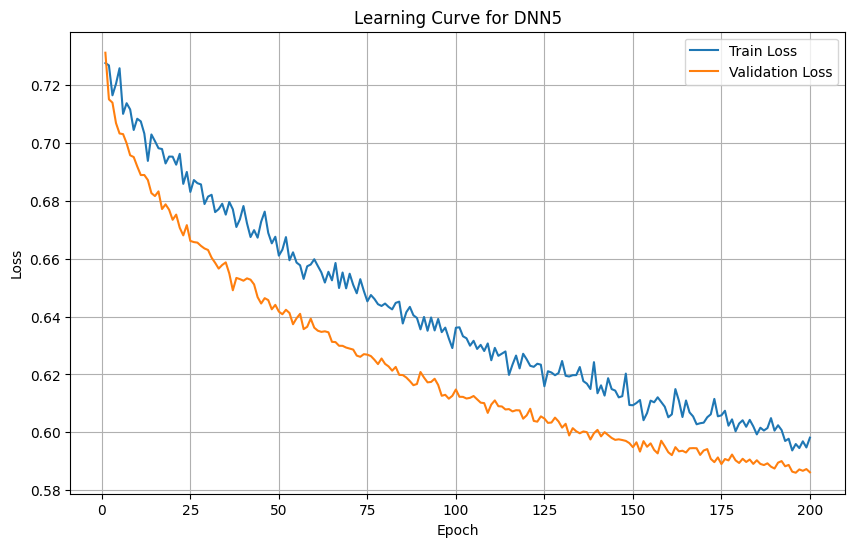

In [9]:
best_params=study.best_params
model = DNN_5(input_dim=X_train_tensor.shape[1],
              dropout1=best_params["dropout1"],
              dropout2=best_params["dropout2"],
              ).to(device)
# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"],weight_decay=best_params["weight_decay"])
criterion = nn.BCELoss()

num_epochs=200
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val.squeeze())
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN5')
plt.legend()
plt.grid()
plt.show()

Accuracy: 60.48%
Precision: 0.4812
Recall: 0.7829
F1 Score: 0.5960
Matthews Correlation Coefficient: 0.2790
Specificity: 0.4991


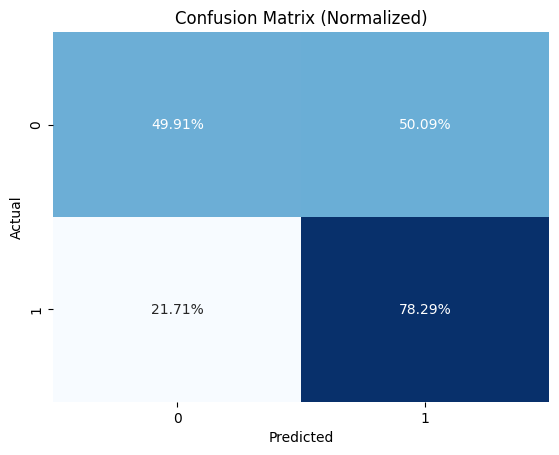

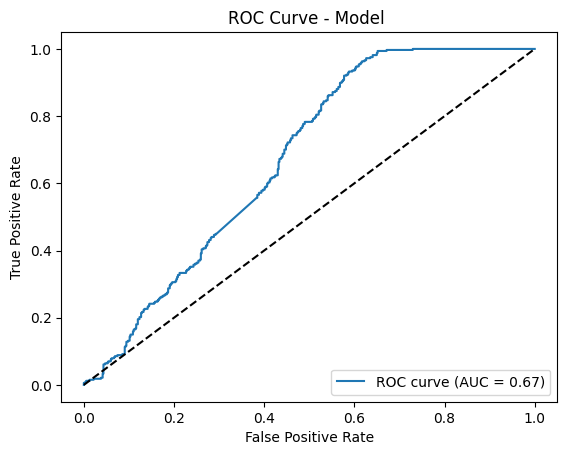

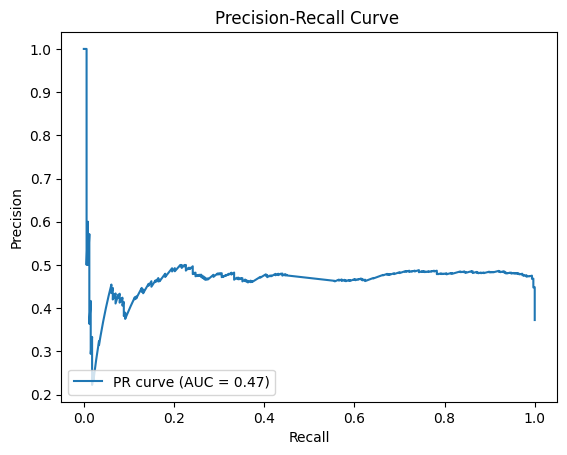

In [10]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs >0.49).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [11]:
# モデルと構造を保存
torch.save(model.state_dict(), 'model_params/DNN_5.pth')




In [12]:
from torchsummary import summary
summary(model, input_size=(X_train_tensor.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             960
       BatchNorm1d-2                   [-1, 32]              64
            Linear-3                   [-1, 16]             528
       BatchNorm1d-4                   [-1, 16]              32
            Linear-5                    [-1, 8]             136
       BatchNorm1d-6                    [-1, 8]              16
           Dropout-7                    [-1, 8]               0
            Linear-8                    [-1, 4]              36
       BatchNorm1d-9                    [-1, 4]               8
          Dropout-10                    [-1, 4]               0
           Linear-11                    [-1, 1]               5
Total params: 1,785
Trainable params: 1,785
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back